In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("unpivoted_football.csv")
df["goal_diff"] = df["team1goal_count"]-df["team2goal_count"]

In [3]:
df.columns

Index(['date_GMT', 'referee', 'Game Week', 'odds_ft_over25', 'stadium_name',
       'team1name', 'team1ppg', 'team1goal_count', 'team1goal_count_half_time',
       'team1goal_timings', 'team1corner_count', 'team1yellow_cards',
       'team1red_cards', 'team1first_half_cards', 'team1second_half_cards',
       'team1shots', 'team1shots_on_target', 'team1shots_off_target',
       'team1fouls', 'team1possession', 'odds_ft_team1win', 'team2name',
       'team2ppg', 'team2goal_count', 'team2goal_count_half_time',
       'team2goal_timings', 'team2corner_count', 'team2yellow_cards',
       'team2red_cards', 'team2first_half_cards', 'team2second_half_cards',
       'team2shots', 'team2shots_on_target', 'team2shots_off_target',
       'team2fouls', 'team2possession', 'odds_ft_team2win', 'game_id', 'ha',
       'goal_diff'],
      dtype='object')

In [4]:
df["class"] = np.where(df["goal_diff"].gt(0), 1, np.where(df["goal_diff"].eq(0), 0, 2))

In [5]:
groups = df.loc[:,['team1name', 'team1goal_count', 'odds_ft_team1win', 'team1goal_count_half_time', 
                   'team2goal_count', 'team2goal_count_half_time', 'team1shots', 
                   'team1shots_on_target', 'class']].groupby('team1name')

In [6]:
lag = 5


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset.iloc[i:(i+look_back), :].values
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

X = []
y = []
odds = []

for k, group in groups:
    if len(group)>lag:
        X_new, y_new = create_dataset(group.drop(["team1name"], axis=1), look_back=lag)
        X.append(X_new)
        y.append(y_new)

In [7]:
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
n_class_var = len(np.unique(y))
y = keras.utils.to_categorical(y)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

In [10]:
split_idx = int(len(y)*0.70)

X_train = X[:split_idx]
X_test = X[split_idx:]

y_train = y[:split_idx]
y_test = y[split_idx:]

In [11]:
def create_model(optimizer="sgd"):
    model = keras.Sequential(
        [
            keras.layers.LSTM(32, input_shape=(lag,X.shape[-1])),
            keras.layers.Dropout(0.2),

            keras.layers.Dense(12, activation="relu"),
            keras.layers.Dense(n_class_var, activation="softmax")
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

Epoch 1/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0888 - accuracy: 0.3800
Epoch 2/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0678 - accuracy: 0.4428
Epoch 3/30
139/139 [==============================] - 0s 2ms/step - loss: 1.0613 - accuracy: 0.4686
Epoch 4/30
139/139 [==============================] - 0s 2ms/step - loss: 1.0547 - accuracy: 0.4772
Epoch 5/30
139/139 [==============================] - 0s 2ms/step - loss: 1.0498 - accuracy: 0.4731
Epoch 6/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0503 - accuracy: 0.4790
Epoch 7/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0460 - accuracy: 0.4785
Epoch 8/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0412 - accuracy: 0.4763
Epoch 9/30
139/139 [==============================] - 0s 2ms/step - loss: 1.0431 - accuracy: 0.4812
Epoch 10/30
139/139 [==============================] - 0s 3ms/step - loss: 1.0415 - accuracy: 0.4781

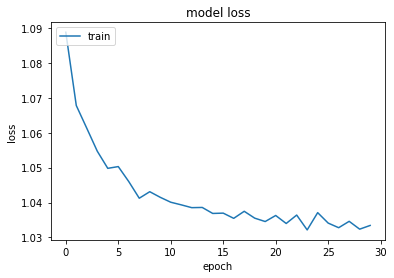

In [12]:
model = create_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

print(classification_report(np.argmax(y_test, axis=1), y_pred))

0.37407797681770283
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.38      0.41      0.39       336
           2       0.37      0.63      0.47       345

    accuracy                           0.37       949
   macro avg       0.25      0.35      0.29       949
weighted avg       0.27      0.37      0.31       949



C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
